In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter as sg
from scipy.interpolate import interp1d

sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("husl")

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


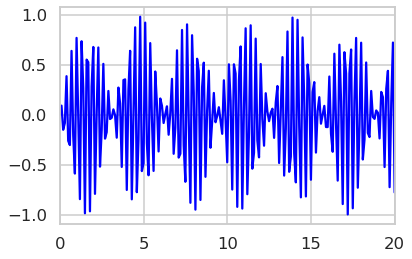

In [27]:
x = np.arange(0, 20.1, 0.1)
y = abs(np.sin(x)) * np.sin(x*20)

fig, ax = plt.subplots()
ax.plot(x, y, c='b')
ax.set_xlim(0, 20)
plt.show()

In [50]:
from scipy.signal import hilbert, chirp

duration = 1.0
fs = 400.0
samples = int(fs*duration)
t = np.arange(samples) / fs
    
# signal = chirp(t, 20.0, t[-1], 100.0)
# signal *= (1.0 + 0.5 * np.sin(2.0*np.pi*3.0*t) )

analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * fs

Text(0.5, 0, 'time in seconds')

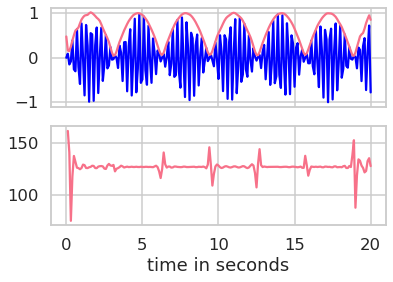

In [51]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(x, y, c="b")
ax[0].plot(x, amplitude_envelope)
ax[1].plot(x[1:], instantaneous_frequency)
ax[1].set_xlabel("time in seconds")

In [5]:
def get_envelope_v1(x, y):
    x_list, y_list = list(x), list(y)
    assert len(x_list) == len(y_list)
    
    # First data
    ui, ux, uy = [0], [x_list[0]], [y_list[0]]
    li, lx, ly = [0], [x_list[0]], [y_list[0]]

    # Find upper peaks and lower peaks
    for i in range(1, len(x_list)-1):
        if y_list[i] >= y_list[i-1] and y_list[i] >= y_list[i+1]:
            ui.append(i)
            ux.append(x_list[i])
            uy.append(y_list[i])
        if y_list[i] <= y_list[i-1] and y_list[i] <= y_list[i+1]:
            li.append(i)
            lx.append(x_list[i])
            ly.append(y_list[i])

    # Last data
    ui.append(len(x_list)-1)
    ux.append(x_list[-1])
    uy.append(y_list[-1])
    li.append(len(y_list)-1)
    lx.append(x_list[-1])
    ly.append(y_list[-1])  

    if len(ux) == 2 or len(lx) == 2:
        return [], []
    
    else:
        func_ub = interp1d(ux, uy, kind='cubic', bounds_error=False)
        func_lb = interp1d(lx, ly, kind='cubic', bounds_error=False)

        ub, lb = [], []
        for i in x_list:
            ub = func_ub(x_list)
            lb = func_lb(x_list)

        ub = np.array([y, ub]).max(axis=0)
        lb = np.array([y, lb]).min(axis=0)

        return ub, lb

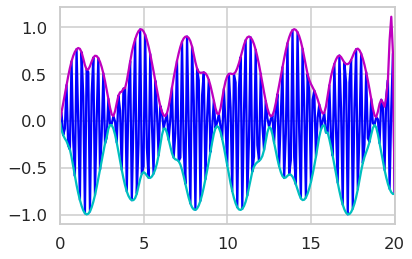

In [32]:
uy, ly = get_envelope_v1(x, y)

fig, ax = plt.subplots()
ax.plot(x, y, c="b")
ax.plot(x, uy, c="m")
ax.plot(x, ly, c="c")
ax.set_xlim(0, 20)
plt.show()

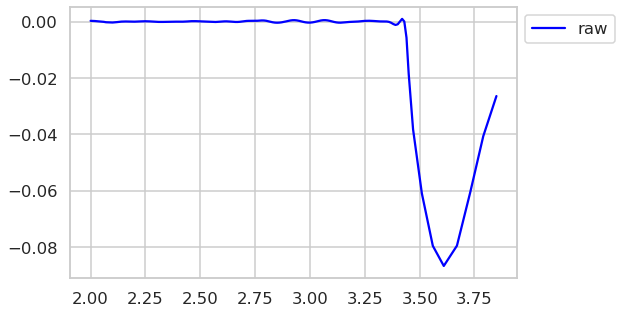

In [2]:
X = np.loadtxt("x4.csv")
Y = np.loadtxt("y4.csv")

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(X, Y, c='b', label="raw")
ax.legend(loc='upper left', bbox_to_anchor=(1., 1))

plt.show()

In [3]:
y_sg = sg(Y, 15, 2, mode="nearest")

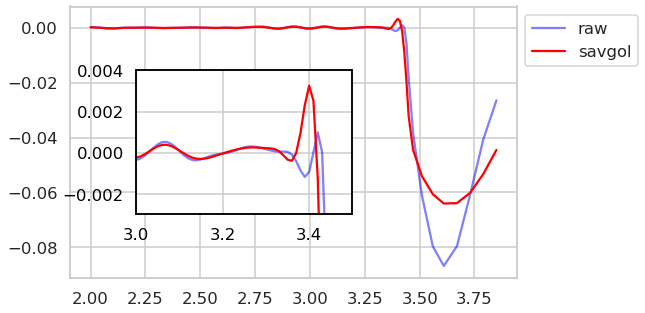

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(X, Y, c='b', alpha=0.5, label="raw")
ax.plot(X, y_sg, c='red', label="savgol")

axin = inset_axes(ax, width=3, height=2, loc="center left", borderpad=4)
axin.spines['bottom'].set_color('k')
axin.spines['top'].set_color('k')
axin.spines['right'].set_color('k')
axin.spines['left'].set_color('k')
axin.tick_params(axis="both", colors="k")

axin.plot(X, Y, c='b', alpha=0.5)
axin.plot(X, y_sg, c='red')
axin.set_xlim(3, 3.5)
axin.set_ylim(-0.003, 0.004)

ax.legend(loc='upper left', bbox_to_anchor=(1., 1))

plt.show()

In [6]:
ub, lb = get_envelope_v1(X, Y)

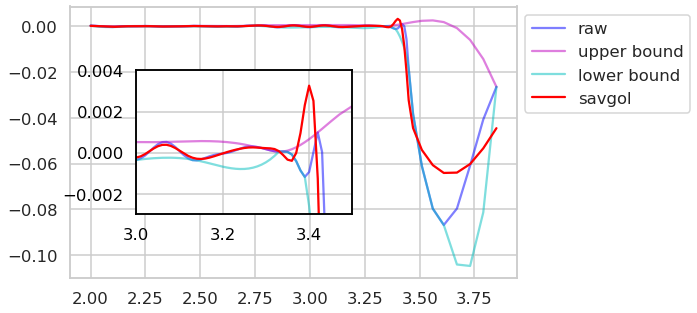

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(X, Y, c='b', alpha=0.5, label="raw")
ax.plot(X, ub, c="m", alpha=0.5, label="upper bound")
ax.plot(X, lb, c="c", alpha=0.5, label="lower bound")
ax.plot(X, y_sg, c='red', label="savgol")

axin = inset_axes(ax, width=3, height=2, loc="center left", borderpad=4)
axin.spines['bottom'].set_color('k')
axin.spines['top'].set_color('k')
axin.spines['right'].set_color('k')
axin.spines['left'].set_color('k')
axin.tick_params(axis="both", colors="k")

axin.plot(X, Y, c='b', alpha=0.5)
axin.plot(X, ub, c="m", alpha=0.5)
axin.plot(X, lb, c="c", alpha=0.5)
axin.plot(X, y_sg, c='red')
axin.set_xlim(3, 3.5)
axin.set_ylim(-0.003, 0.004)

ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
plt.show()

In [8]:
def get_envelope_v2(x, y):
    x_list, y_list = list(x), list(y)
    assert len(x_list) == len(y_list)
    
    # First data
    ui, ux, uy = [0], [x_list[0]], [y_list[0]]
    li, lx, ly = [0], [x_list[0]], [y_list[0]]

    # Find upper peaks and lower peaks
    for i in range(1, len(x_list)-1):
        if y_list[i] >= y_list[i-1] and y_list[i] >= y_list[i+1]:
            ui.append(i)
            ux.append(x_list[i])
            uy.append(y_list[i])
        if y_list[i] <= y_list[i-1] and y_list[i] <= y_list[i+1]:
            li.append(i)
            lx.append(x_list[i])
            ly.append(y_list[i])

    # Last data
    ui.append(len(x_list)-1)
    ux.append(x_list[-1])
    uy.append(y_list[-1])
    li.append(len(y_list)-1)
    lx.append(x_list[-1])
    ly.append(y_list[-1])  

    # upper through check
    ux_chk, uy_chk = [x_list[0]], [y_list[0]]
    for ii in range(1, len(ui)):
        slope = (uy[ii]-uy[ii-1])/(ux[ii]-ux[ii-1])
        intercept = -slope*ux[ii] + uy[ii]
        
        for xi in range(ui[ii-1], ui[ii]):
            y_pred = slope*x_list[xi] + intercept
            if y_pred < y_list[xi] and (x_list[xi] not in ux_chk) and (y_list[xi] not in uy_chk):
                ux_chk.append(x_list[xi])
                uy_chk.append(y_list[xi])
        ux_chk.append(x_list[ui[ii]])
        uy_chk.append(y_list[ui[ii]])
        
    # lower through check
    lx_chk, ly_chk = [x_list[0]], [y_list[0]]
    for ii in range(1, len(li)):
        slope = (ly[ii]-ly[ii-1])/(lx[ii]-lx[ii-1])
        intercept = -slope*lx[ii] + ly[ii]
        
        for xi in range(li[ii-1], li[ii]):
            y_pred = slope*x_list[xi] + intercept
            if y_pred > y_list[xi] and (x_list[xi] not in lx_chk) and (y_list[xi] not in ly_chk):
                lx_chk.append(x_list[xi])
                ly_chk.append(y_list[xi])
        lx_chk.append(x_list[li[ii]])
        ly_chk.append(y_list[li[ii]])    
    
    if len(ux_chk) == 2 or len(lx_chk) == 2:
        return [], []
    
    else:
        func_ub = interp1d(ux_chk, uy_chk, kind='cubic', bounds_error=False)
        func_lb = interp1d(lx_chk, ly_chk, kind='cubic', bounds_error=False)

        ub, lb = [], []
        for i in x_list:
            ub = func_ub(x_list)
            lb = func_lb(x_list)

        ub = np.array([y, ub]).max(axis=0)
        lb = np.array([y, lb]).min(axis=0)

        return ub, lb

In [9]:
ub, lb = get_envelope_v2(X, Y)

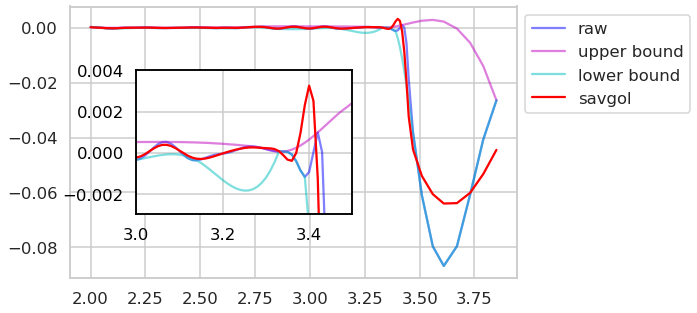

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(X, Y, c='b', alpha=0.5, label="raw")
ax.plot(X, ub, c="m", alpha=0.5, label="upper bound")
ax.plot(X, lb, c="c", alpha=0.5, label="lower bound")
ax.plot(X, y_sg, c='red', label="savgol")

axin = inset_axes(ax, width=3, height=2, loc="center left", borderpad=4)
axin.spines['bottom'].set_color('k')
axin.spines['top'].set_color('k')
axin.spines['right'].set_color('k')
axin.spines['left'].set_color('k')
axin.tick_params(axis="both", colors="k")

axin.plot(X, Y, c='b', alpha=0.5)
axin.plot(X, ub, c="m", alpha=0.5)
axin.plot(X, lb, c="c", alpha=0.5)
axin.plot(X, y_sg, c='red')
axin.set_xlim(3, 3.5)
axin.set_ylim(-0.003, 0.004)

ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
plt.show()

In [11]:
def savgol(x, y, box_size, recur=1):
    ub, lb = get_envelope_v2(x, y)
        
    for _ in range(recur):
        y = sg(y, box_size, 2, mode='nearest')    
        if len(ub) > 0:
            y = np.where(y > ub, ub, np.where(y < lb, lb, y))
        
    return y

In [12]:
y_savgol = savgol(X, Y, 15)

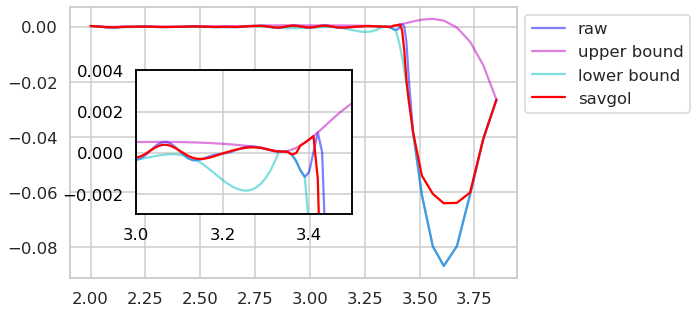

In [13]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(X, Y, c='b', alpha=0.5, label="raw")
ax.plot(X, ub, c="m", alpha=0.5, label="upper bound")
ax.plot(X, lb, c="c", alpha=0.5, label="lower bound")
ax.plot(X, y_savgol, c='red', label="savgol")

axin = inset_axes(ax, width=3, height=2, loc="center left", borderpad=4)
axin.spines['bottom'].set_color('k')
axin.spines['top'].set_color('k')
axin.spines['right'].set_color('k')
axin.spines['left'].set_color('k')
axin.tick_params(axis="both", colors="k")

axin.plot(X, Y, c='b', alpha=0.5)
axin.plot(X, ub, c="m", alpha=0.5)
axin.plot(X, lb, c="c", alpha=0.5)
axin.plot(X, y_savgol, c='red')
axin.set_xlim(3, 3.5)
axin.set_ylim(-0.003, 0.004)

ax.legend(loc='upper left', bbox_to_anchor=(1., 1))
plt.show()